# Tuning Empirical Gaussian FLORIS Model to SCADA Using Interpolation and Mathematical Optimization

In this notebook, the Empirical Gaussian FLORIS Model (emgauss) will be tuned to align with SCADA data using an interpolation/mathematical optimization technique that determines the parameter value(s) that minimize the error (mean squared error) between SCADA and FLORIS energy ratios. 

The parameters of interest in this tuning exercise are 'wake_expansion_rates' (1st expansion rate) and 'horizontal_deflection_gain_D'. These parameters are associated with the following operating scenarios:

wake_expansion_rates => basline case

horizontal_deflection_gain_D => wake steering case

## Import Relevant Libraries

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import flasc.model_fitting.floris_tuning as ft
import flasc.utilities.floris_tools as ftools
from flasc.analysis import energy_ratio as er
from flasc.analysis.energy_ratio_input import EnergyRatioInput
from flasc.utilities.tuner_utilities import resim_floris
from flasc.utilities.utilities_examples import load_floris_smarteole

In [2]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Load and Inspect SCADA

Load pre-processed SCADA data with power curve fiiltering and northing calibration applied, and inspect the data.

In [3]:
# Specify SCADA file path and load the dataframe
scada_path = os.path.join(
    Path.cwd(), "postprocessed", "df_scada_data_60s_filtered_and_northing_calibrated.ftr"
)
df_scada = pd.read_feather(scada_path)

# Preview SCADA
df_scada.head()

,time,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,ws_000,ws_001,...,is_operation_normal_005,is_operation_normal_006,wind_vane_005,target_yaw_offset_005,control_mode,wd_smarteole,ws_smarteole,pow_ref_smarteole,ti,wd
0,2020-02-17 16:30:00,2023.746948,2045.376953,2031.724976,NaN,2028.063965,2032.461060,1983.390991,13.066,12.337,...,True,True,3.299,-0.0,baseline,251.041672,12.582482,2021.060059,0.11,251.377068
1,2020-02-17 16:31:00,1959.036011,2050.572998,2034.890991,NaN,2017.777954,1943.764038,2046.568970,12.091,13.057,...,True,True,1.825,-0.0,baseline,251.282684,12.823891,2022.767212,0.11,251.485048
2,2020-02-17 16:32:00,2053.658936,2032.191040,2011.870972,NaN,NaN,2052.092041,2039.948975,13.381,12.213,...,True,True,8.314,-0.0,baseline,252.874130,12.859400,2034.417480,0.11,253.473037
3,2020-02-17 16:33:00,2044.296997,2060.478027,1995.057983,NaN,NaN,2008.868042,2058.000000,14.345,13.141,...,True,True,2.384,-0.0,baseline,251.341553,13.426766,2039.458252,0.11,251.104001
4,2020-02-17 16:34:00,2058.281006,2042.703003,2031.723999,NaN,NaN,1819.896973,2059.760010,14.338,12.723,...,True,True,17.271,-0.0,baseline,253.343018,13.225105,2048.116943,0.11,255.679234


In [4]:
df_scada.columns

Index(['time', 'pow_000', 'pow_001', 'pow_002', 'pow_003', 'pow_004',
       'pow_005', 'pow_006', 'ws_000', 'ws_001', 'ws_002', 'ws_003', 'ws_004',
       'ws_005', 'ws_006', 'wd_000', 'wd_001', 'wd_002', 'wd_003', 'wd_004',
       'wd_005', 'wd_006', 'is_operation_normal_000',
       'is_operation_normal_001', 'is_operation_normal_002',
       'is_operation_normal_003', 'is_operation_normal_004',
       'is_operation_normal_005', 'is_operation_normal_006', 'wind_vane_005',
       'target_yaw_offset_005', 'control_mode', 'wd_smarteole', 'ws_smarteole',
       'pow_ref_smarteole', 'ti', 'wd'],
      dtype='object')

## Prepare SCADA for Computing Energy Ratios (Baseline + Wake Steering Cases)

The energy ratio class as presently implemented requires explicit identification of the dataframe of the reference wind direction, wind speed, and power columns: "wd," "ws," and "pow_ref." Here, these will be set equal to the reference variables used in the SMARTEOLE wake steering experiment, which was computed in "02_download_and_format_dataset.ipynb".

In [5]:
# Specify offsets
start_of_offset = 200  # deg
end_of_offset = 240  # deg

In [6]:
# Limit SCADA to this region
df_scada = df_scada[
    (df_scada.wd_smarteole > (start_of_offset - 20))
    & (df_scada.wd_smarteole < (end_of_offset + 20))
]

In [7]:
# Assign wd, ws and pow ref and subset SCADA based on reference variables
# used in the SMARTEOLE wake steering experiment (TODO reference the experiment)
df_scada = df_scada.assign(
    wd=lambda df_: df_["wd_smarteole"],
    ws=lambda df_: df_["ws_smarteole"],
    pow_ref=lambda df_: df_["pow_ref_smarteole"],
)

In [8]:
# For tuning grab the reference, control and test turbines
ref_turbs = [0, 1, 2, 6]
test_turbs = [4]
control_turbs = [5]

In [9]:
# Split SCADA into baseline and wake steeering (controlled)
df_scada_baseline = df_scada[df_scada.control_mode == "baseline"]
df_scada_controlled = df_scada[df_scada.control_mode == "controlled"]

## Load FLORIS model

Specify the path of the Empirical Gaussian FLORIS Model (emgauss) YAML file. Instantiate the FLORIS model using this file. 

In [10]:
fm, _ = load_floris_smarteole(wake_model="emgauss")

# Define D
D = fm.core.farm.rotor_diameters[0]

In [11]:
## Tune the wake expansion

In [12]:
wake_expansion_rates = np.arange(start=0.0005, stop=0.025, step=0.0005)

In [13]:
df_scada = df_scada_baseline.copy()
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=["wake", "wake_velocity_parameters", "empirical_gauss", "wake_expansion_rates"],
    value_candidates=wake_expansion_rates,
    df_scada_in=df_scada,
    fm_in=fm,
    param_idx=0,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    wd_min=200,  # FOCUS ON WAKE REGION WITH CONTROL
    wd_max=225,  # FOCUS ON WAKE REGION WITH CONTROL
)
print(floris_wake_losses, scada_wake_loss)

[43.27689076 43.14938946 43.02208633 42.89491991 42.76795681 42.64123563
 42.51456112 42.38781212 42.26106336 42.13444535 42.00752876 41.88067234
 41.75392085 41.62696185 41.49992442 41.3729645  41.24591003 41.11873161
 40.99155735 40.86430637 40.73721487 40.61018549 40.48326752 40.35645899
 40.22977133 40.10310542 39.97661195 39.85015656 39.72402267 39.59823444
 39.47271448 39.34761402 39.22287124 39.09839253 38.97415297 38.85027817
 38.72681744 38.60367319 38.48086052 38.35853918 38.23665281 38.11512427
 37.99400435 37.87323163 37.75282657 37.63283634 37.51324767 37.39406121
 37.27528243] 39.91532211996801


Text(0, 0.5, 'Percent Wake Loss')

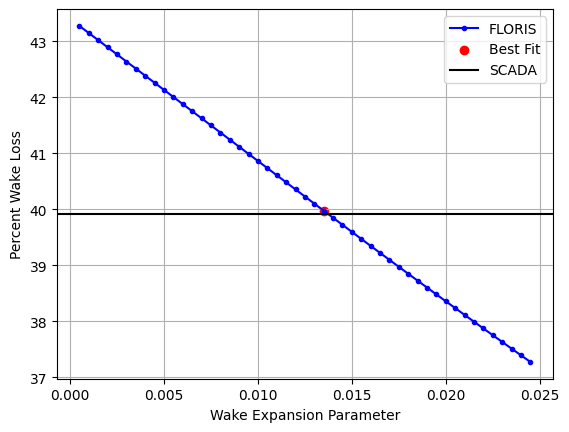

In [14]:
fig, ax = plt.subplots()
best_param = ft.select_best_wake_model_parameter(
    floris_wake_losses, scada_wake_loss, wake_expansion_rates, ax=ax
)
ax.set_xlabel("Wake Expansion Parameter")
ax.set_ylabel("Percent Wake Loss")

In [15]:
# Compare energy ratios before and after tuning
# Apply the best fit
fm_tuned = fm.copy()
fm_tuned.set_param(
    ["wake", "wake_velocity_parameters", "empirical_gauss", "wake_expansion_rates"],
    param_idx=0,
    value=best_param,
)

Text(0.5, 1.0, 'Comparing pre/post tuning FLORIS')

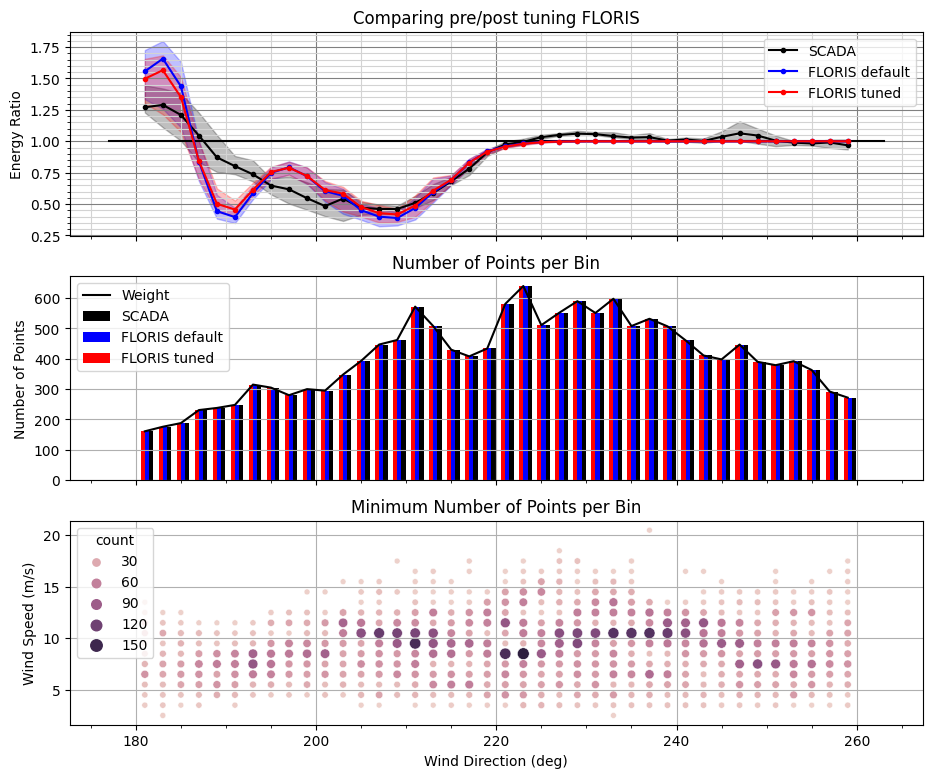

In [16]:
df_floris_pre = resim_floris(fm, df_scada)
df_floris_tuned = resim_floris(fm_tuned, df_scada)

er_in = EnergyRatioInput(
    [df_scada, df_floris_pre, df_floris_tuned], ["SCADA", "FLORIS default", "FLORIS tuned"]
)

er_out = er.compute_energy_ratio(
    er_in,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
    N=40,
)
ax = er_out.plot_energy_ratios(
    overlay_frequency=True, color_dict={"SCADA": "k", "FLORIS default": "b", "FLORIS tuned": "r"}
)
ax[0].set_title("Comparing pre/post tuning FLORIS")

In [17]:
# Assign the new parameter
fm = fm_tuned

# Identify wd_std

In [18]:
# Use the same wd region
min_wd = 200
max_wd = 225

df_scada = df_scada_baseline.copy()
df_scada = df_scada[df_scada.wd > min_wd]
df_scada = df_scada[df_scada.wd <= max_wd]

min_ws = np.floor(np.min([df_scada_baseline.ws.min(), df_scada_baseline.ws.min()]))
max_ws = np.ceil(np.max([df_scada_baseline.ws.max(), df_scada_baseline.ws.max()]))

In [19]:
# Make approximate tables
wd_array = np.arange(min_wd, max_wd, 1.0)
ws_array = np.arange(min_ws, max_ws, 1.0)

df_approx = ftools.calc_floris_approx_table(
    fm, wd_array=wd_array, ws_array=ws_array, ti_array=np.array([0.1])
)

2024-04-09 18:56:05 Generating a df_approx table of FLORIS solutions covering a total of 525 cases.
2024-04-09 18:56:06 Finished calculating the FLORIS solutions for the dataframe.


In [20]:
df_scada = df_scada[
    ["ti", "wd", "ws", "pow_000", "pow_001", "pow_002", "pow_003", "pow_004", "pow_005", "pow_006"]
]

In [21]:
df_scada.columns

Index(['ti', 'wd', 'ws', 'pow_000', 'pow_001', 'pow_002', 'pow_003', 'pow_004',
       'pow_005', 'pow_006'],
      dtype='object')

In [22]:
# Select the values to check
wd_std_range = [0, 1, 2, 3, 4]

er_error, df_list = ft.sweep_wd_std_for_er(
    wd_std_range,
    df_scada,
    df_approx,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
)

2024-04-09 18:56:06 Warning: not mirroring NaNs from the raw data to the FLORIS predictions. This may skew your energy ratios.
2024-04-09 18:56:06 Identified the following grid type: 2d.
2024-04-09 18:56:06 Warning: the values in df[wd] exceed the range in the precalculated solutions df_fi_approx[wd].
2024-04-09 18:56:06    minimum/maximum value in df:        (200.003, 224.998)
2024-04-09 18:56:06    minimum/maximum value in df:        (200.003, 224.998)
2024-04-09 18:56:06    minimum/maximum value in df_approx: (200.000, 224.000)
2024-04-09 18:56:06 Mapping the precalculated solutions from FLORIS to the dataframe...
2024-04-09 18:56:06   Creating a gridded interpolant with interpolation method 'linear'.
2024-04-09 18:56:06      Interpolating pow for all turbines...
2024-04-09 18:56:06 Finished interpolation in 0.014 seconds.


2024-04-09 18:56:06 Warning: not mirroring NaNs from the raw data to the FLORIS predictions. This may skew your energy ratios.
2024-04-09 18:56:06 Identified the following grid type: 2d.
2024-04-09 18:56:06 Warning: the values in df[wd] exceed the range in the precalculated solutions df_fi_approx[wd].
2024-04-09 18:56:06    minimum/maximum value in df:        (200.003, 224.998)
2024-04-09 18:56:06    minimum/maximum value in df:        (200.003, 224.998)
2024-04-09 18:56:06    minimum/maximum value in df_approx: (200.000, 224.000)
2024-04-09 18:56:06 Mapping the precalculated solutions from FLORIS to the dataframe...
2024-04-09 18:56:06   Creating a gridded interpolant with interpolation method 'linear'.
2024-04-09 18:56:06      Interpolating pow for all turbines...
2024-04-09 18:56:06 Finished interpolation in 0.006 seconds.
2024-04-09 18:56:06 Warning: not mirroring NaNs from the raw data to the FLORIS predictions. This may skew your energy ratios.
2024-04-09 18:56:06 Identified the 

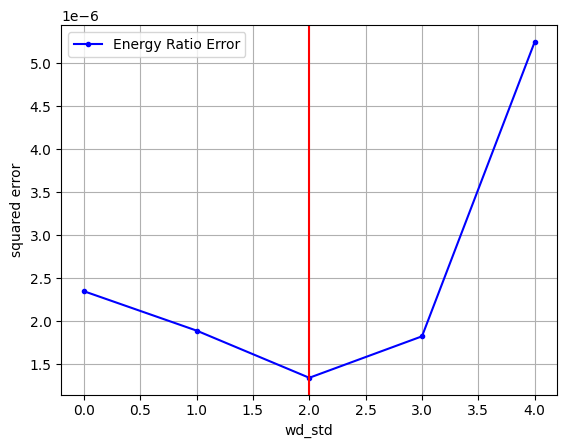

In [23]:
# Select the best result
fig, ax = plt.subplots()
best_param = ft.select_best_wd_std(er_error, wd_std_range, ax=ax)

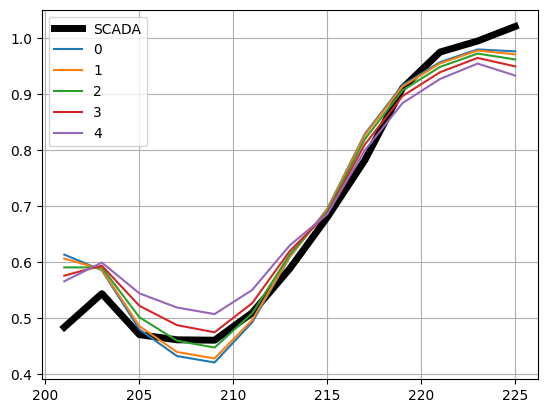

In [24]:
# Plot the values
fig, ax = plt.subplots()

ax.plot(df_list[0]["wd_bin"], df_list[0]["SCADA"].values, color="k", lw=5, label="SCADA")

for i, wd_std in enumerate(wd_std_range):
    ax.plot(df_list[i]["wd_bin"], df_list[i]["FLORIS"].values, label=wd_std)

ax.grid()
ax.legend()

## Evaluate horizontal deflection gains

In [25]:
hor_def_gains = np.arange(start=0.5, stop=5, step=0.5)

In [26]:
# Set the yaw angle matrix
yaw_vec = df_scada_controlled.wind_vane_005

yaw_angles = np.zeros((yaw_vec.shape[0], 7))
yaw_angles[:, control_turbs[0]] = yaw_vec

In [27]:
floris_uplifts, scada_uplift = ft.sweep_deflection_parameter_for_total_uplift(
    parameter=[
        "wake",
        "wake_deflection_parameters",
        "empirical_gauss",
        "horizontal_deflection_gain_D",
    ],
    value_candidates=hor_def_gains,
    df_scada_baseline_in=df_scada_baseline,
    df_scada_wakesteering_in=df_scada_controlled,
    fm_in=fm,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    yaw_angles_wakesteering=yaw_angles,
    ws_min=5,
    wd_min=205,
    wd_max=225,
)

Text(0, 0.5, 'Percent Uplift')

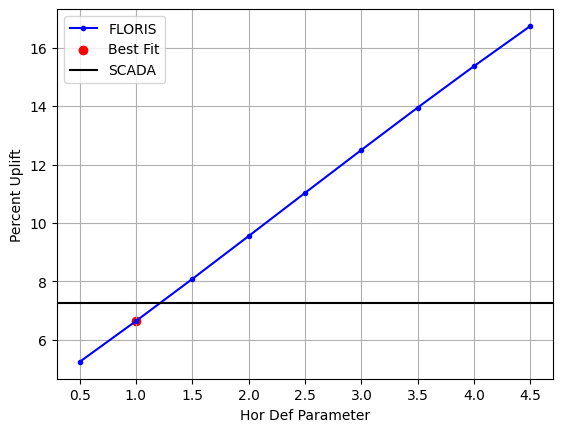

In [28]:
fig, ax = plt.subplots()
best_param = ft.select_best_wake_model_parameter(floris_uplifts, scada_uplift, hor_def_gains, ax=ax)
ax.set_xlabel("Hor Def Parameter")
ax.set_ylabel("Percent Uplift")